In [1]:
!pip install opencv-python-headless tensorflow scikit-learn joblib tqdm


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os


data_path = '/content/drive/MyDrive/DataCollection'
print("Classes:", os.listdir(data_path))


Classes: ['data_1_person', 'data_2_person', 'data_3_person', 'data_4_person', 'data_6_person', 'data_7_person', 'data_5_person', 'data_8_person', 'data_9_person', 'data_10_person', 'data_11_person', 'data_12_person', 'data_13_person', 'data_14_person', 'data_15_person']


In [4]:
from PIL import Image, ImageOps
import os

def horizontal_flip_images(root_path):
    for class_folder in os.listdir(root_path):
        class_path = os.path.join(root_path, class_folder)
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(class_path, img_name)
                try:
                    image = Image.open(img_path)


                    if image.mode == 'RGBA':
                        image = image.convert('RGB')

                    flipped = ImageOps.mirror(image)
                    flipped_name = img_name.rsplit('.', 1)[0] + '_flipped.jpg'
                    flipped.save(os.path.join(class_path, flipped_name), 'JPEG')
                except Exception as e:
                    print(f"Skipping {img_name}: {e}")

print("Flipping images...")
horizontal_flip_images(data_path)


Flipping images...


In [7]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_with_labels(path, img_size=(128, 128)):
    images, labels = [], []
    class_names = sorted(os.listdir(path))
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        folder = os.path.join(path, class_name)
        for img_file in os.listdir(folder):
            try:
                img = load_img(os.path.join(folder, img_file), target_size=img_size)
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(class_to_idx[class_name])
            except Exception as e:
                print("Skipped:", img_file, "Error:", e)

    return np.array(images), np.array(labels), class_to_idx

X, y, label_map = load_images_with_labels(data_path)
print("Loaded:", len(X), "images")


Loaded: 4052 images


In [8]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
import os
import shutil
import random

def split_and_save_dataset(input_dir, output_dir, train_ratio=0.8):
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if not images:
            print(f"⚠️ No images found in: {class_name}")
            continue

        random.shuffle(images)
        split_idx = int(len(images) * train_ratio)
        train_images = images[:split_idx]
        test_images = images[split_idx:]

        # Create class folders in train and test
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        # Copy train images
        for img in train_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(train_class_dir, img))

        # Copy test images
        for img in test_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(test_class_dir, img))

        print(f"✅ {class_name}: {len(train_images)} train, {len(test_images)} test images saved.")

    print("\n📁 Dataset split and saved at:", output_dir)


input_dir = '/content/drive/MyDrive/DataCollection'  #  original dataset
output_dir = 'yolo_classification_dataset_new'  # Destination for train/test split
split_and_save_dataset(input_dir, output_dir)


✅ data_1_person: 153 train, 39 test images saved.
✅ data_2_person: 128 train, 32 test images saved.
✅ data_3_person: 166 train, 42 test images saved.
✅ data_4_person: 108 train, 28 test images saved.
✅ data_6_person: 73 train, 19 test images saved.
✅ data_7_person: 115 train, 29 test images saved.
✅ data_5_person: 81 train, 21 test images saved.
✅ data_8_person: 99 train, 25 test images saved.
✅ data_9_person: 121 train, 31 test images saved.
✅ data_10_person: 83 train, 21 test images saved.
✅ data_11_person: 115 train, 29 test images saved.
✅ data_12_person: 97 train, 25 test images saved.
✅ data_13_person: 78 train, 20 test images saved.
✅ data_14_person: 96 train, 24 test images saved.
✅ data_15_person: 102 train, 26 test images saved.

📁 Dataset split and saved at: yolo_classification_dataset_new


In [12]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.1/994.1 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [13]:
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [15]:

from ultralytics import YOLO


model = YOLO('yolov8n-cls.pt')

model.train(data='yolo_classification_dataset', epochs=15, imgsz=224)


Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=yolo_classification_dataset, epochs=15, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

100%|██████████| 5.35M/5.35M [00:00<00:00, 112MB/s]


AMP: checks passed ✅


train: Scanning /content/yolo_classification_dataset/train... 3236 images, 0 corrupt: 100%|██████████| 3236/3236 [00:02<00:00, 1584.67it/s]

train: New cache created: /content/yolo_classification_dataset/train.cache



val: Scanning /content/yolo_classification_dataset/test... 816 images, 0 corrupt: 100%|██████████| 816/816 [00:00<00:00, 1105.67it/s]


val: New cache created: /content/yolo_classification_dataset/test.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train2
Starting training for 15 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/15      0.27G      2.809         16        224:   4%|▍         | 8/203 [00:01<00:21,  8.89it/s]

       1/15      0.27G        2.8         16        224:   6%|▋         | 13/203 [00:02<00:28,  6.68it/s]
100%|██████████| 755k/755k [00:00<00:00, 22.9MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:03<00:00,  7.30it/s]

                   all      0.591      0.936



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:03<00:00,  7.33it/s]

                   all      0.803          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:03<00:00,  6.77it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:05<00:00,  4.90it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:04<00:00,  5.23it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:03<00:00,  7.05it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:03<00:00,  7.11it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:03<00:00,  7.30it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:03<00:00,  7.30it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      10/15     0.348G     0.1125          4        224: 100%|██████████| 203/203 [00:27<00:00,  7.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:04<00:00,  5.24it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


      11/15     0.355G    0.09594          4        224: 100%|██████████| 203/203 [00:25<00:00,  7.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:04<00:00,  5.33it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


      12/15     0.363G    0.09712          4        224: 100%|██████████| 203/203 [00:26<00:00,  7.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:03<00:00,  6.77it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


      13/15     0.373G    0.09703          4        224: 100%|██████████| 203/203 [00:26<00:00,  7.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:03<00:00,  7.14it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


      14/15     0.381G     0.0831          4        224: 100%|██████████| 203/203 [00:26<00:00,  7.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:03<00:00,  7.10it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


      15/15     0.389G    0.08083          4        224: 100%|██████████| 203/203 [00:26<00:00,  7.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:03<00:00,  7.30it/s]

                   all      0.995          1



15 epochs completed in 0.132 hours.
Optimizer stripped from runs/classify/train2/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 3.0MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,454,095 parameters, 0 gradients, 3.3 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/yolo_classification_dataset/train... found 3236 images in 15 classes ✅ 
val: /content/yolo_classification_dataset/test... found 816 images in 15 classes ✅ 
test: /content/yolo_classification_dataset/test... found 816 images in 15 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 26/26 [00:05<00:00,  4.97it/s]


                   all      0.996          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa5598c8190>
curves: []
curves_results: []
fitness: 0.9981617629528046
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9963235259056091, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9981617629528046}
save_dir: PosixPath('runs/classify/train2')
speed: {'preprocess': 0.0978823406861537, 'inference': 0.44445013357927543, 'loss': 0.00038997548970468526, 'postprocess': 0.0005446776968626057}
task: 'classify'
top1: 0.9963235259056091
top5: 1.0

In [24]:
import os

base_dir = 'runs/classify'
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.pt'):
            print("✅ Found model:", os.path.join(root, file))


✅ Found model: runs/classify/train2/weights/best.pt
✅ Found model: runs/classify/train2/weights/last.pt


In [29]:
from ultralytics import YOLO


model = YOLO('runs/classify/train2//weights/best.pt')


metrics = model.val(data='yolo_classification_dataset')


print(f"\n✅ Top-1 Accuracy: {metrics.top1:.4f}")
print(f"✅ Top-5 Accuracy: {metrics.top5:.4f}")


Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,454,095 parameters, 0 gradients, 3.3 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/yolo_classification_dataset/train... found 3236 images in 15 classes ✅ 
val: /content/yolo_classification_dataset/test... found 816 images in 15 classes ✅ 
test: /content/yolo_classification_dataset/test... found 816 images in 15 classes ✅ 


val: Scanning /content/yolo_classification_dataset/test... 816 images, 0 corrupt: 100%|██████████| 816/816 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 51/51 [00:06<00:00,  8.32it/s]


                   all      0.996          1
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val3

✅ Top-1 Accuracy: 0.9963
✅ Top-5 Accuracy: 1.0000


In [44]:

import shutil


source_path = 'runs/classify/train2/weights/best.pt'
destination_path = '/content/drive/MyDrive/saved_model'


os.makedirs(destination_path, exist_ok=True)


shutil.copy2(source_path, destination_path)

print(f"✅ Model saved to: {destination_path}")


✅ Model saved to: /content/drive/MyDrive/saved_model


Image uploaded: /content/drive/MyDrive/yolo_classification_dataset/test/1/9.png


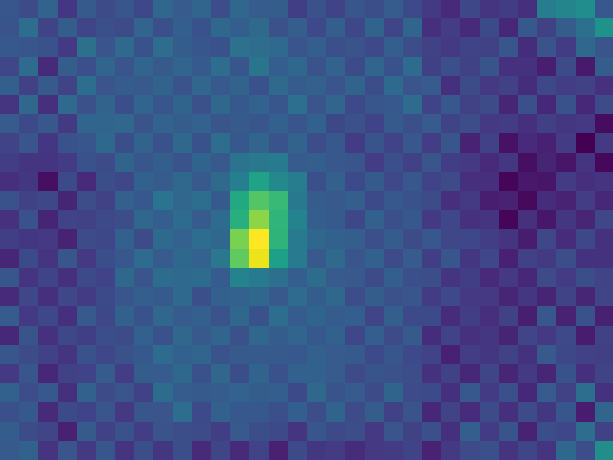

In [31]:

image_path = '/content/drive/MyDrive/yolo_classification_dataset/test/1/9.png'   #single file is uploaded
print("Image uploaded:", image_path)


try:
  from PIL import Image
  img = Image.open(image_path)
  img.show()
  display(img) # Display image inline
except Exception as e:
  print(f"Error displaying image: {e}")



In [37]:
from ultralytics import YOLO
from PIL import Image

# Load your trained model
model = YOLO('runs/classify/train2/weights/best.pt')  # update path if needed
 # replace with your actual image path

# Predict
image_path = '/content/drive/MyDrive/yolo_classification_dataset/test/1/9.png'
results = model(image_path, imgsz=224)

# Extract predicted class
pred_class_idx = results[0].probs.data.argmax().item()
predicted_class = results[0].names[pred_class_idx]

print(f"\n✅ Predicted Class: {predicted_class}")



image 1/1 /content/drive/MyDrive/yolo_classification_dataset/test/1/9.png: 224x224 data_1_person 1.00, data_4_person 0.00, data_2_person 0.00, data_9_person 0.00, data_11_person 0.00, 3.0ms
Speed: 6.2ms preprocess, 3.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

✅ Predicted Class: data_1_person


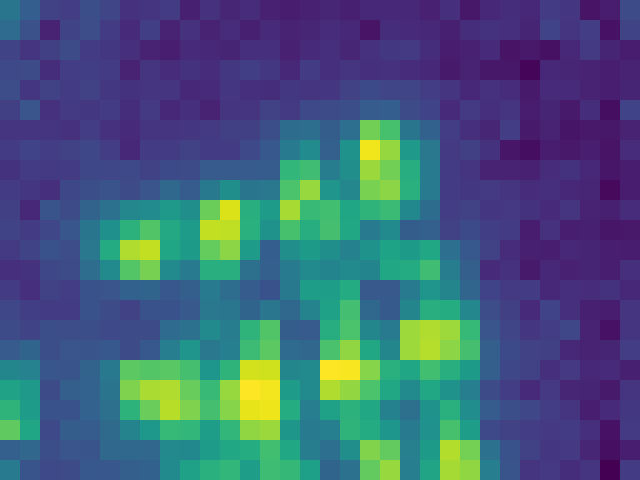


image 1/1 /content/drive/MyDrive/yolo_classification_dataset/test/10/10- (3).png: 224x224 data_10_person 1.00, data_12_person 0.00, data_8_person 0.00, data_2_person 0.00, data_3_person 0.00, 8.0ms
Speed: 16.7ms preprocess, 8.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

✅ Predicted Class: data_10_person


In [43]:
image_path = '/content/drive/MyDrive/yolo_classification_dataset/test/10/10- (3).png'
img = Image.open(image_path)
img.show()
display(img)

results = model(image_path, imgsz=224)

# Extract predicted class
pred_class_idx = results[0].probs.data.argmax().item()
predicted_class = results[0].names[pred_class_idx]

print(f"\n✅ Predicted Class: {predicted_class}")
